In [3]:
## Step 0 - Loads Parameters and Libraries

import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs

#logName = 'Ciena_error_lin0es_20220701-20220715.txt' # Name of file to be parsed
#logName = 'ciena-mini.txt' # Name of file to be parsed
#logName = 'Andriod_2k.log' # Name of file to be parsed
logName = 'trat3_production_1650_1700_20231411_raw.txt' # Name of file to be parsed

log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

In [4]:
## Step 1 - Log Parsing Using Drain

## Drain parameters
st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Parses file, using DrainMethod
print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')


=== Starting Drain Parsing ===
c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\
Parsing file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\trat3_production_1650_1700_20231411_raw.txt


Parsing Progress: 100%|██████████| 638425/638425 [00:51<00:00, 12393.89it/s]


Parsing done. [Time taken: 0:01:39.860908]


In [5]:
## Step 2 - Vector Creation Using TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path
import pandas as pd
import regex as re
import contextlib
import pickle

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors_TFIDF.vec')
    path = Path(path_to_file)
    vectors_tfidf = []

    # Saves transformed file, for further executions
    if (path.is_file()):
        vectors_tfidf = pickle.load(open(path_to_file, 'rb'))
    else:
        # Using TFIDF Vectorizer 
        print("Iniciando encode")
        tr_idf_model  = TfidfVectorizer()
        vectors_tfidf = tr_idf_model.fit_transform(raw_content)
        pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))
    
    print(type(vectors_tfidf))
    return vectors_tfidf

# Creates embeddings for log file
def transform(logName):
    print('Transforming file: ' + os.path.join(input_dir, logName))
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

vector_df = transform(os.path.basename(logName))

Transforming file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\trat3_production_1650_1700_20231411_raw.txt
Iniciando encode
<class 'scipy.sparse._csr.csr_matrix'>


In [6]:
## Optional Step - Checks vector file dimensions

print(type(vector_df))
print(vector_df.shape)
print("The number of lines of the transformed file is {}".format(vector_df.shape[0]))
print("The number of columns of the transformed file is {}".format(vector_df.shape[1]))

<class 'scipy.sparse._csr.csr_matrix'>
(638425, 13076)
The number of lines of the transformed file is 638425
The number of columns of the transformed file is 13076


In [7]:
## Step 3 - Creates matrix of parsed items (variable matrix)

from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import pandas as pd 

## General Parameters

output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
var_df = full_df["ParameterList"]

# Breaks the string into lists
for i, line in var_df.items():
    var_df.at[i] = literal_eval(var_df.at[i])

# Transforms variable list to variable SPARSE matrix
mlb = MultiLabelBinarizer(sparse_output=True)
var_df = mlb.fit_transform(var_df)
print ("The matrix of parsed items has the size {}".format(var_df.shape))
print(type(var_df))

The matrix of parsed items has the size (638425, 179272)
<class 'scipy.sparse._csr.csr_matrix'>


In [8]:
## Step 5 - Creates and normalizes distance matrix, creates variables matrix, creates and normalizes count matrix

from sklearn.metrics.pairwise import pairwise_distances 
import numpy as np

# Using Euclidean Distance between the rows of the TFIDF Matrix
tfidf_distance = pairwise_distances(vector_df, metric="euclidean", n_jobs=-1)
# Normalizes Distance Matrix with Min-Max
min_val = np.min(tfidf_distance)
max_val = np.max(tfidf_distance)
tfidf_distance = (tfidf_distance - min_val) / (max_val - min_val)
print("The dimensions of the distance matrix are {}".format(tfidf_distance.shape))

# Using Jaccard Distance between the rows of the Variable Matrix
var_distance = pairwise_distances(np.asarray(var_df.todense()), metric="jaccard", n_jobs=-1)
print("The dimensions of the variable matrix are {}".format(var_distance.shape))

# Creates Count Matrix using line numbers from log lines as the counter
count_list = []
n = len(tfidf_distance)
count_distance = np.zeros(shape=(n, n), dtype=int)
for i in range(n):
        count_list.append(i)

# Using a Subtraction Distance using the line numbers as a Count Matrix
count_array = np.array(count_list)
for x in count_array:
  for y in count_array:
    count_distance[x,y] = abs(x-y)
# Normalizes Distance Matrix with Min-Max
min_val = np.min(count_distance)
max_val = np.max(count_distance)
count_distance = (count_distance - min_val) / (max_val - min_val)
print("The dimensions of the count matrix are {}".format(count_distance.shape))

MemoryError: Unable to allocate 2.97 TiB for an array with shape (638425, 638425) and data type float64

In [ ]:
## Optional Step - Saves and/or loads matrices

# Saving matrices

# print("Saving distance matrix")
# np.save("tfidf_distance.csv", tfidf_distance)
# print("Saving variables matrix")
# np.save("var_distance.csv", var_distance)
# print("Saving count matrix")
# np.save("count_distance.csv", count_distance)

# print("Loading distance matrix")
# tfidf_distance = np.load("tfidf_distance.csv")
# print("Loading count matrix")
# count_distance = np.load("count_distance.csv")
# print("Loading variables matrix")
# var_distance = np.load("var_distance.csv")

In [53]:
## Step 6 - Applies weights to the matrices

# Using alpha to define the weight of the TFIDF Matrix,  Beta to define the weight of the Variable Matrix,
# and Gamma to define the weight of the Count Matrix
alpha = 0.3
beta = 0.5
gamma = 0.2

if alpha+beta+gamma > 1:
   raise Exception("Values have to sum 1!")

# New matrices, corrected by the weights
tfidf_distance_wtd = np.dot(alpha,tfidf_distance)
var_distance_wtd = np.dot(beta, var_distance)
count_distance_wtd = np.dot(gamma, count_distance)

# Sums remaining matrices
distance_matrix = np.asarray(tfidf_distance_wtd + var_distance_wtd + count_distance_wtd)

In [54]:
## Step 7 - Choosing one clustering method (DBSCAN/7.1, HDBSCAN/7.2, or K-Means/7.3)

## Step 7.1 - Clusters with DBSCAN

from sklearn.cluster import DBSCAN

# eps:float, default=0.5
# The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
# This is not a maximum bound on the distances of points within a cluster. 
# This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

# min_samples:int, default=5
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

# algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
# The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

# leaf_size:int, default=30
# Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

# p:float, default=None
# The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2 (equivalent to the Euclidean distance).

# n_jobs:int, default=None
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

clusterer = DBSCAN(eps=0.75,min_samples=2,metric='precomputed',algorithm='auto',leaf_size=30,n_jobs=-1)
clusterer.fit(distance_matrix)

print ("The number of clusters is {}".format(clusterer.labels_.max()))
print ("The clusters of each element are {}".format(clusterer.labels_))

## Checks number of outliers
cont = np.count_nonzero(clusterer.labels_ == -1)

print("The number of outliers is {}".format(cont))
print("The total amount of elements is {}".format(len(clusterer.labels_)))

The number of clusters is 4
The clusters of each element are [0 0 0 ... 0 0 0]
The number of outliers is 1
The total amount of elements is 2000


In [21]:
## Step 7.2 - Clusters with HDBSCAN

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

# min_cluster_size:int, optional (default=5)
# The minimum size of clusters; single linkage splits that contain fewer points than this will 
# be considered points “falling out” of a cluster rather than a cluster splitting into two new clusters.

# min_samples:int, optional (default=None)
# The number of samples in a neighbourhood for a point to be considered a core point.

# p :int, optional (default=None)
# p value to use if using the minkowski metric.

# alpha :float, optional (default=1.0)
# A distance scaling parameter as used in robust single linkage. See [3] for more information.

# cluster_selection_epsilon: float, optional (default=0.0)
# A distance threshold. Clusters below this value will be merged.
# See [5] for more information.

# algorithm :string, optional (default=’best’)
# Exactly which algorithm to use; hdbscan has variants specialised for different characteristics 
# of the data. By default this is set to best which chooses the “best” algorithm given the nature 
# of the data. You can force other options if you believe you know better. Options are: 'best',
# 'generic', 'prims_kdtree', 'prims_balltree', 'boruvka_kdtree' and 'boruvka_balltree'

# leaf_size: int, optional (default=40)
# If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. 
# This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.

# cluster_selection_method :string, optional (default=’eom’)
# The method used to select clusters from the condensed tree. The standard approach for HDBSCAN is 
# to use an Excess of Mass algorithm to find the most persistent clusters. Alternatively you can 
# instead select the clusters at the leaves of the tree – this provides the most fine grained and 
# homogeneous clusters. Options are: 'eom' and 'leaf'

# allow_single_cluster :bool, optional (default=False)
# By default HDBSCAN will not produce a single cluster, setting this to True will override this 
# and allow single cluster results in the case that you feel this is a valid result for your dataset.

## Clusters with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=None,metric='precomputed',
                            cluster_selection_epsilon=0.7, alpha=1.0, leaf_size=40, 
                            allow_single_cluster=False,cluster_selection_method='eom',
                            gen_min_span_tree=True)


clusterer.fit(distance_matrix)

print ("The number of clusters is {}".format(clusterer.labels_.max()))
print ("The clusters of each element are {}".format(clusterer.labels_))

## Checks number of outliers
cont = np.count_nonzero(clusterer.labels_ == -1)

print("The number of outliers is {}".format(cont))
print("The total amount of elements is {}".format(len(clusterer.labels_)))

The number of cluster is 7
The clusters of each element are [6 6 6 ... 4 4 4]
The number of outliers is 248
The total amount of elements is 2000


In [23]:
## Step 7.3 - Clusters with K-Means

from sklearn.cluster import KMeans

# n_clusters {int, default=8}: The number of clusters to form as well as the number of centroids to generate.

# init {‘k-means++’, ‘random’, callable or array-like of shape (n_clusters, n_features), default=’k-means++’}: 
# Method for initialization: ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical 
# probability distribution of the points’ contribution to the overall inertia. This technique speeds up convergence. 
# The algorithm implemented is “greedy k-means++”. It differs from the vanilla k-means++ by making several trials 
# at each sampling step and choosing the best centroid among them. ‘random’: choose n_clusters observations (rows) 
# at random from data for the initial centroids. 

# n_init {‘auto’ or int, default=10}: Number of times the k-means algorithm is run with different centroid seeds. 
# The final results is the best output of n_init consecutive runs in terms of inertia. Several runs are recommended 
# for sparse high-dimensional problems (see Clustering sparse data with k-means).

# max_iter {int, default=300}: Maximum number of iterations of the k-means algorithm for a single run.

# tol {float, default=1e-4}: Relative tolerance with regards to Frobenius norm of the difference in the cluster 
# centers of two consecutive iterations to declare convergence.

# verbose {int, default=0}: Verbosity mode.

# random_state {int, RandomState instance or None, default=None}: Determines random number generation for 
# centroid initialization. Use an int to make the randomness deterministic. See Glossary.

# copy_x {bool, default=True}: When pre-computing distances it is more numerically accurate to center the data 
# first. If copy_x is True (default), then the original data is not modified. If False, the original data is 
# modified, and put back before the function returns, but small numerical differences may be introduced by 
# subtracting and then adding the data mean. Note that if the original data is not C-contiguous, a copy will 
# be made even if copy_x is False. If the original data is sparse, but not in CSR format, a copy will be made 
# even if copy_x is False.

# algorithm {“lloyd”, “elkan”, default=”lloyd”}: K-means algorithm to use. The classical EM-style algorithm 
# is "lloyd". The "elkan" variation can be more efficient on some datasets with well-defined clusters, by 
# using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array 
# of shape (n_samples, n_clusters).

clusterer = KMeans(n_clusters=6, random_state=0, n_init=10)
clusterer.fit(distance_matrix)

cluster_num = clusterer.labels_.max()
print ("The number of clusters is {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("The clusters of each element are {}".format(cluster_labels))

The number of clusters is 5
The clusters of each element are [1 1 1 ... 2 2 2]


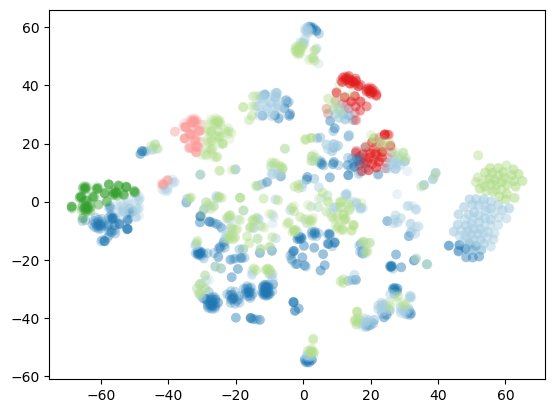

In [24]:
## Step 8 - Plots clustering results, regardless of method chosen

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

projection = TSNE(metric='precomputed', init='random').fit_transform(distance_matrix)

color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

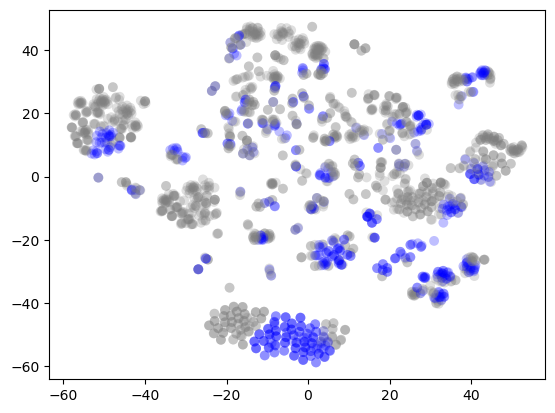

In [25]:
## Step 8.1 - Plots again, with just one cluster selected

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

cluster = 0 # Cluster to be picked
custom_palette = []
cont = 0
while cont < clusterer.labels_.max()+1:
    if cont != cluster:
        custom_palette.append((0.5,0.5,0.5)) # If not the cluster chosen, plots in gray
    else:
        custom_palette.append(((0,0,1))) # If the cluster chosen, plots in blue
    cont += 1

projection = TSNE(metric='precomputed', init='random').fit_transform(distance_matrix)
cluster_colors = [custom_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

In [55]:
## Step 9 - Creates a list of lists representing the clusters

import pandas as pd
import numpy as np

## General Parameters

cluster_idxs = []
cluster_lines = []
cluster_topics = []
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
elem_df = full_df["Content"]

# Creates blank lists
for elem in range (clusterer.labels_.max()+1):
    cluster_idxs.append([])
    cluster_lines.append([])
    cluster_topics.append([])

# Populate the lists with cluster elements
for idx, elem in np.ndenumerate(clusterer.labels_):
  if elem != -1:
    cluster_idxs[elem].append(idx[0])
    cluster_lines[elem].append(elem_df[idx[0]])

# Check sizes of each cluster
#for i in range(len(cluster_idxs)):
#   print(len(cluster_idxs[i]))

In [82]:
## Step 10 - Eliminates stopwords on a given cluster, and runs the topic modeling

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import gensim
import nltk

# Parameters
#nltk.download('stopwords') # In case the user does not have the stopwords from NLTK
stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'edu', 'use']) # Custom stopwords

# Converts sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Removes stopwords from each sentence
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Finds topics of a given cluster
def find_topics(cluster_list, cluster_number, num_topics):
    # Converts to words
    data_words = list(sent_to_words(cluster_list[cluster_number]))
    # Removes stop words - OPTIONAL
    #data_words = remove_stopwords(data_words)
    # Creates dictionary
    id2word = corpora.Dictionary(data_words)
    # Creates corpora
    corpus = [id2word.doc2bow(text) for text in data_words]
    # Builds LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
    # Prints topics
    #pprint(lda_model.print_topics())
    #pprint(lda_model.get_topic_terms(0))
    return lda_model

topics = find_topics(cluster_lines, 0, 1)
top_topics = {'Topic_' + str(i): [token for token, score in topics.show_topic(i, topn=10)] for i in range(0, topics.num_topics)}
words = top_topics['Topic_0']

In [86]:
## Step 11 - Creates a list of the top topic words for each cluster

cluster_topics = []

for cluster in range (clusterer.labels_.max()):
    topics = find_topics(cluster_lines, cluster, 1)
    top_topics = {'Topic_' + str(i): [token for token, score in topics.show_topic(i, topn=10)] for i in range(0, topics.num_topics)}
    words = top_topics['Topic_0']
    cluster_topics.append(words)

[['false', 'true', 'phonestatusbar', 'com', 'rect', 'android', 'activitymanager', 'vis', 'policy', 'newval'], ['ams', 'amap', 'android', 'calling', 'com', 'is', 'app'], ['getdataenabled', 'phoneintfmgr', 'subid', 'phoneid', 'retval', 'true'], ['audiomanager', 'effecttype', 'playsoundeffect']]


In [95]:
## Step 11 - Finds most similar line inside the cluster to the words of the topic

from nltk.tokenize import WhitespaceTokenizer

tk = WhitespaceTokenizer()

def find_similar_lines(cluster_list, cluster_number, word_list):
    closest_line = 0
    similar_tokens = 0
    max_similarity = 0
    for idx, line in enumerate(cluster_list[cluster_number]):
        tokenized_line = tk.tokenize(line.lower())
        for token in tokenized_line:
            if token in word_list:
                similar_tokens += 1
        #print ("Line {} has {} identical tokens".format(idx, similar_tokens))
        if similar_tokens > max_similarity:
           max_similarity = similar_tokens
           closest_line = idx
        similar_tokens = 0
    if (max_similarity != 0):
        print("In cluster {}, the closest line is {}, with {} identical tokens to the topic".format(cluster_number, closest_line, max_similarity)) 
        print("The topic is composed by the following words: {}".format(word_list))
        print("Line {} is: {}".format(closest_line, cluster_list[cluster_number][closest_line]))   
    else:
        print("No good lines found for cluster {}".format(cluster_number))
    print("\n")
    return closest_line, max_similarity          

for cluster in range(len(cluster_topics)):
    find_similar_lines(cluster_lines, cluster, cluster_topics[cluster])

In cluster 0, the closest line is 73, with 2 identical tokens to the topic
The topic is composed by the following words: ['false', 'true', 'phonestatusbar', 'com', 'rect', 'android', 'activitymanager', 'vis', 'policy', 'newval']
Line 73 is: 03-17 16:13:45.316  1702 14640 D WindowManager: interceptKeyTq keycode=4 interactive=true keyguardActive=false policyFlags=2b000002 down true canceled false


In cluster 1, the closest line is 0, with 3 identical tokens to the topic
The topic is composed by the following words: ['ams', 'amap', 'android', 'calling', 'com', 'is', 'app']
Line 0 is: 03-17 16:13:40.305  3664  3807 D TelephonyManager: getNeighboringCellInfo calling app is com.amap.android.ams


No good lines found for cluster 2


In cluster 3, the closest line is 0, with 1 identical tokens to the topic
The topic is composed by the following words: ['audiomanager', 'effecttype', 'playsoundeffect']
Line 0 is: 03-17 16:15:36.912  3714  3714 V AudioManager: playSoundEffect   effectType: 0


